# Applying Statistics

## Overview

This lab will continue to build foundational understandings of descriptive statistics, focusing on the various approaches toward measuring deviation.  Much of this lab will focus on the ability to identify encrypted data based solely on descriptive statistics.

## Goals

By the end of this lab, you should be able to:

 * Explain the differences between variance, standard deviation, and median absolute deviation
 * Write code that will produce the variance for a dataset
 * Write code that will produce the standard deviation for a dataset
 * Write code that will produce the median absolute deviation for a dataset
 * Write code that can evaluate the likelihood that a specific set of data represents encrypted information
 
## Estimated Time: 30 - 45 minutes




# <img src="../images/task.png" width=20 height=20> Task 3.1

Please use the next cell to import both the Pandas and Numpy libraries.  Import Numpy as np and Pandas as pd.

In [1]:
import numpy as np
import pandas as pd

In this lab we will work with a set of files of varying types.  All of the files that we will use are located in `../data/files` and each file type is in its own directory.  Let's begin by creating a dictionary that maps file types to the names of the files that are available.

# <img src="../images/task.png" width=20 height=20> Task 3.2

Using the `os` library, retrieve a list of all of the directory names in the `../data/files` directory.  Store these in a list that represents the types of files that we will be working with.

In [2]:
import os as os
file_types = os.listdir('../data/files/')
file_types

['UNIX Binaries',
 'Windows binaries',
 'Archives',
 'SVG Files',
 'Word docs',
 'JPEG Files',
 'Text files']

Now that we have the file types, we are ready to obtain a list of the filenames for each type of file.

# <img src="../images/task.png" width=20 height=20> Task 3.3

Enumerate the files in each of the directories, assigning the list of files to a dictionary where the key is the file type.

In [3]:
files = {}
for filetype in file_types:
    files[filetype] = os.listdir(f'../data/files/{filetype}/')

files

{'UNIX Binaries': ['cat',
  'dd',
  'bash',
  'date',
  'dash',
  'chmod',
  'cp',
  'echo',
  'csh',
  'df'],
 'Windows binaries': ['WinSCP.exe', 'dd.exe'],
 'Archives': ['Archive 3.zip',
  'Archive 4.zip',
  'Archive 2.zip',
  'Archive.zip'],
 'SVG Files': ['SVG 10.svg',
  'SVG 4.svg',
  'SVG 3.svg',
  'SVG 5.svg',
  'SVG 8.svg',
  'SVG 6.svg',
  'SVG 2.svg',
  'SVG 7.svg',
  'SVG 9.svg',
  'SVG 1.svg'],
 'Word docs': ['Doc 1.doc',
  'Doc 3.doc',
  'Doc 4.doc',
  'Doc 5.doc',
  'Doc 2.doc'],
 'JPEG Files': ['IMG_4136.JPG',
  'IMG_4135.JPG',
  'IMG_4128.JPG',
  'IMG_4132.JPG',
  'IMG_4133.JPG',
  'IMG_4129.JPG',
  'IMG_4134.JPG'],
 'Text files': ['Fourth.txt', 'Third.txt', 'Second.txt', 'First.txt']}

Let's pause and talk about where we are heading.  We are wondering, or theorizing, that the statistical behavior of the bytes in different types of files might be a useful tool for predicting what that file content is.  Our very specific plan is to use statistics to identify encrypted data, but if we can identify other file types, that's an added bonus.

Why is this useful and how could it be used?  While we are applying this task to examining files, we can use the technique in different ways.  If we stick with the idea of files, might it be interesting to identify encrypted attachments in email messages?  If we generalize away from files, could it be useful to find encrypted data streams on unusual ports?  Or, alternatively, to find streams that are *not* encrypted?  These are just a few ways that we might use the techniques discussed here.

# <img src="../images/task.png" width=20 height=20> Task 3.4

Since we are dealing with arbitrary data, it is reasonable to assume that at least some, if not most, of that data is binary.  Python provides the *binascii* library, which has some very useful helper functions for examining binary data.

Import the `binascii` library.  When that is done, read the first 32 bytes of every file and use the `hexlify()` convenience method from `binascii` to print these file headers out.

In [4]:
import binascii
for filetype in files:
    for filename in files[filetype]:
        with open(f'../data/files/{filetype}/{filename}', 'rb') as f:
            chunk = f.read(32)
            print(f'{binascii.hexlify(chunk)}  --  {filename}')

b'cffaedfe07000001030000000200000011000000580600008500200000000000'  --  cat
b'cffaedfe07000001030000000200000011000000a80600008500200000000000'  --  dd
b'cffaedfe07000001030000000200000012000000300700008500200000000000'  --  bash
b'cffaedfe07000001030000000200000011000000580600008500200000000000'  --  date
b'cffaedfe07000001030000000200000011000000f80600008500200000000000'  --  dash
b'cffaedfe07000001030000000200000011000000580600008500200000000000'  --  chmod
b'cffaedfe07000001030000000200000011000000580600008500200000000000'  --  cp
b'cffaedfe07000001030000000200000011000000b80500008500200000000000'  --  echo
b'cffaedfe07000001030000000200000013000000680700008500200000000000'  --  csh
b'cffaedfe07000001030000000200000012000000880600008500200000000000'  --  df
b'4d5a50000200000004000f00ffff0000b80000000000000040001a000000fb70'  --  WinSCP.exe
b'4d5a50000200000004000f00ffff0000b80000000000000040001a0000000000'  --  dd.exe
b'504b0304140008000800ab80154f0000000000000000f75d2b000c0020004

No doubt when you look at these examples you can see obvious patterns.  If you weren't already aware of it, nearly all file types, especially binary file types, have some kind of *file header.*  As this name implies, it is found at the head, or beginning, of the file.  It contains various data structures that are specific to the file type in question.  For example, if we are looking at an image file, perhaps it contains a version number for the image file format, a bit depth, the overall dimensions of the image, compression information if the image is compressed, etc.

While file header information can be used to determine file type, it might be interesting to be able to take a random sample of a hunk of a file or packet stream and make a good guess as to what type of data it is *without* seeing the header.  This can allow us to sample parts of data streams and categorize them or to identify files that have unexpected data within them that doesn't fit the normal behavior for the file type based on the header.

## Histograms

When we return to the lecture portion of the course, we will begin by discussing the notion of a histogram in some depth.  A histogram is typically rendered as a bar chart that seeks to visualize how our values cluster.  Imagine we had random values between zero and one hundred.  How frequently does each random number occur?  A histogram is the type of diagram used to visualize the answer to this question.

While we can create a histogram showing the frequency with which every value occurs, more typically the values are grouped together into "bins," which are ranges of values.  For example, the values between zero and nine, ten and nineteen, twenty and twenty-nine, etc.

### Important Note!

When plotting a histogram, we must define the number of bins.  With this in mind, we need to be mindful of how the bins are formed.  If we define the number of bins (using an integer), then the bins will all be equal-width.  If we define the bins as a range of values, however, the right-most bin (highest value in the range) may not behave as you expect.

For example, if we were to use the `bins` keyword argument to specify a range of bins such as `range(0,4)`, the bins will effectively use the list of values `[0, 1, 2, 3]`.  This means that the first bin will contain all values from $[0,1)$, where the square bracket indicates that the range is inclusive and the parenthesis indicates that it is exclusive.  Continuing from this point, the bins would have the ranges $[1, 2), [2, 3]$.  Notice the difference in the final bin.  The value three does not appear in its own bin!  Instead, it is grouped with the bin to the left!

Imagine that you wanted to generated a histogram visualizing the frequency with which each byte value appears in a file.  You could do this using `bins=256` to force 256 bins to be generated.  However, you may discover that the automatically generated bins do not quite break on byte boundaries!  As a result, you might want to force it to use `bins=range(0,257)`.  Notice that we use `257` rather than `256`.  This causes the final bin to be $[255, 256]$.  If we were to use `range(0,256)`, our final bin would be $[254, 255]$, which would include 254 and 255 bytes in the same bin, which is not what we want.

You may want to bear this in mind when plotting histograms below.

# <img src="../images/task.png" width=20 height=20> Task 3.5

Let's visualize our files.  Create a function that takes a filename as an argument and produces a histogram of the bytes within that file.  Verify that the function works by passing in a file from our sample data.

When generating a histogram, the default is to generate a histogram with only 10 bins.  We would like to see the frequency of bytes granularly, so set the `bins` keyword argument to be equal to the range of values from 0 to 255.

In [5]:
import matplotlib.pyplot as plt
def plot_file(filename):
    with open(filename, 'rb') as f:
        data = bytearray(f.read())
    plt.figure(figsize=(12,4))
    plt.hist(data, bins=range(0,257))
    plt.title(f'Histogram of {filename}')
    plt.show()

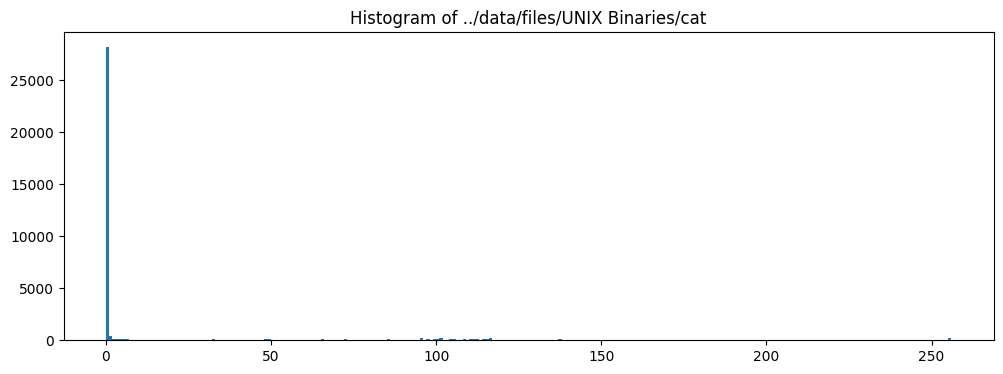

In [6]:
plot_file(f'../data/files/{file_types[0]}/{files[file_types[0]][0]}')

Let's generalize this a bit so that we can plot all of our files in one large plot.

# <img src="../images/task.png" width=20 height=20> Task 3.6

Rewrite your plotting function so that it can accept an axes value to use for the plot.  When you have it working, plot all of the files in a grid that is five plots wide and as high as needed.

In [7]:
def plot_file(filename, axes=plt):
    with open(filename, 'rb') as f:
        data = bytearray(f.read())
    axes.hist(data, bins=range(0,257))
    axes.set_title(filename)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)

42 subplots required
Creating 9x5 grid


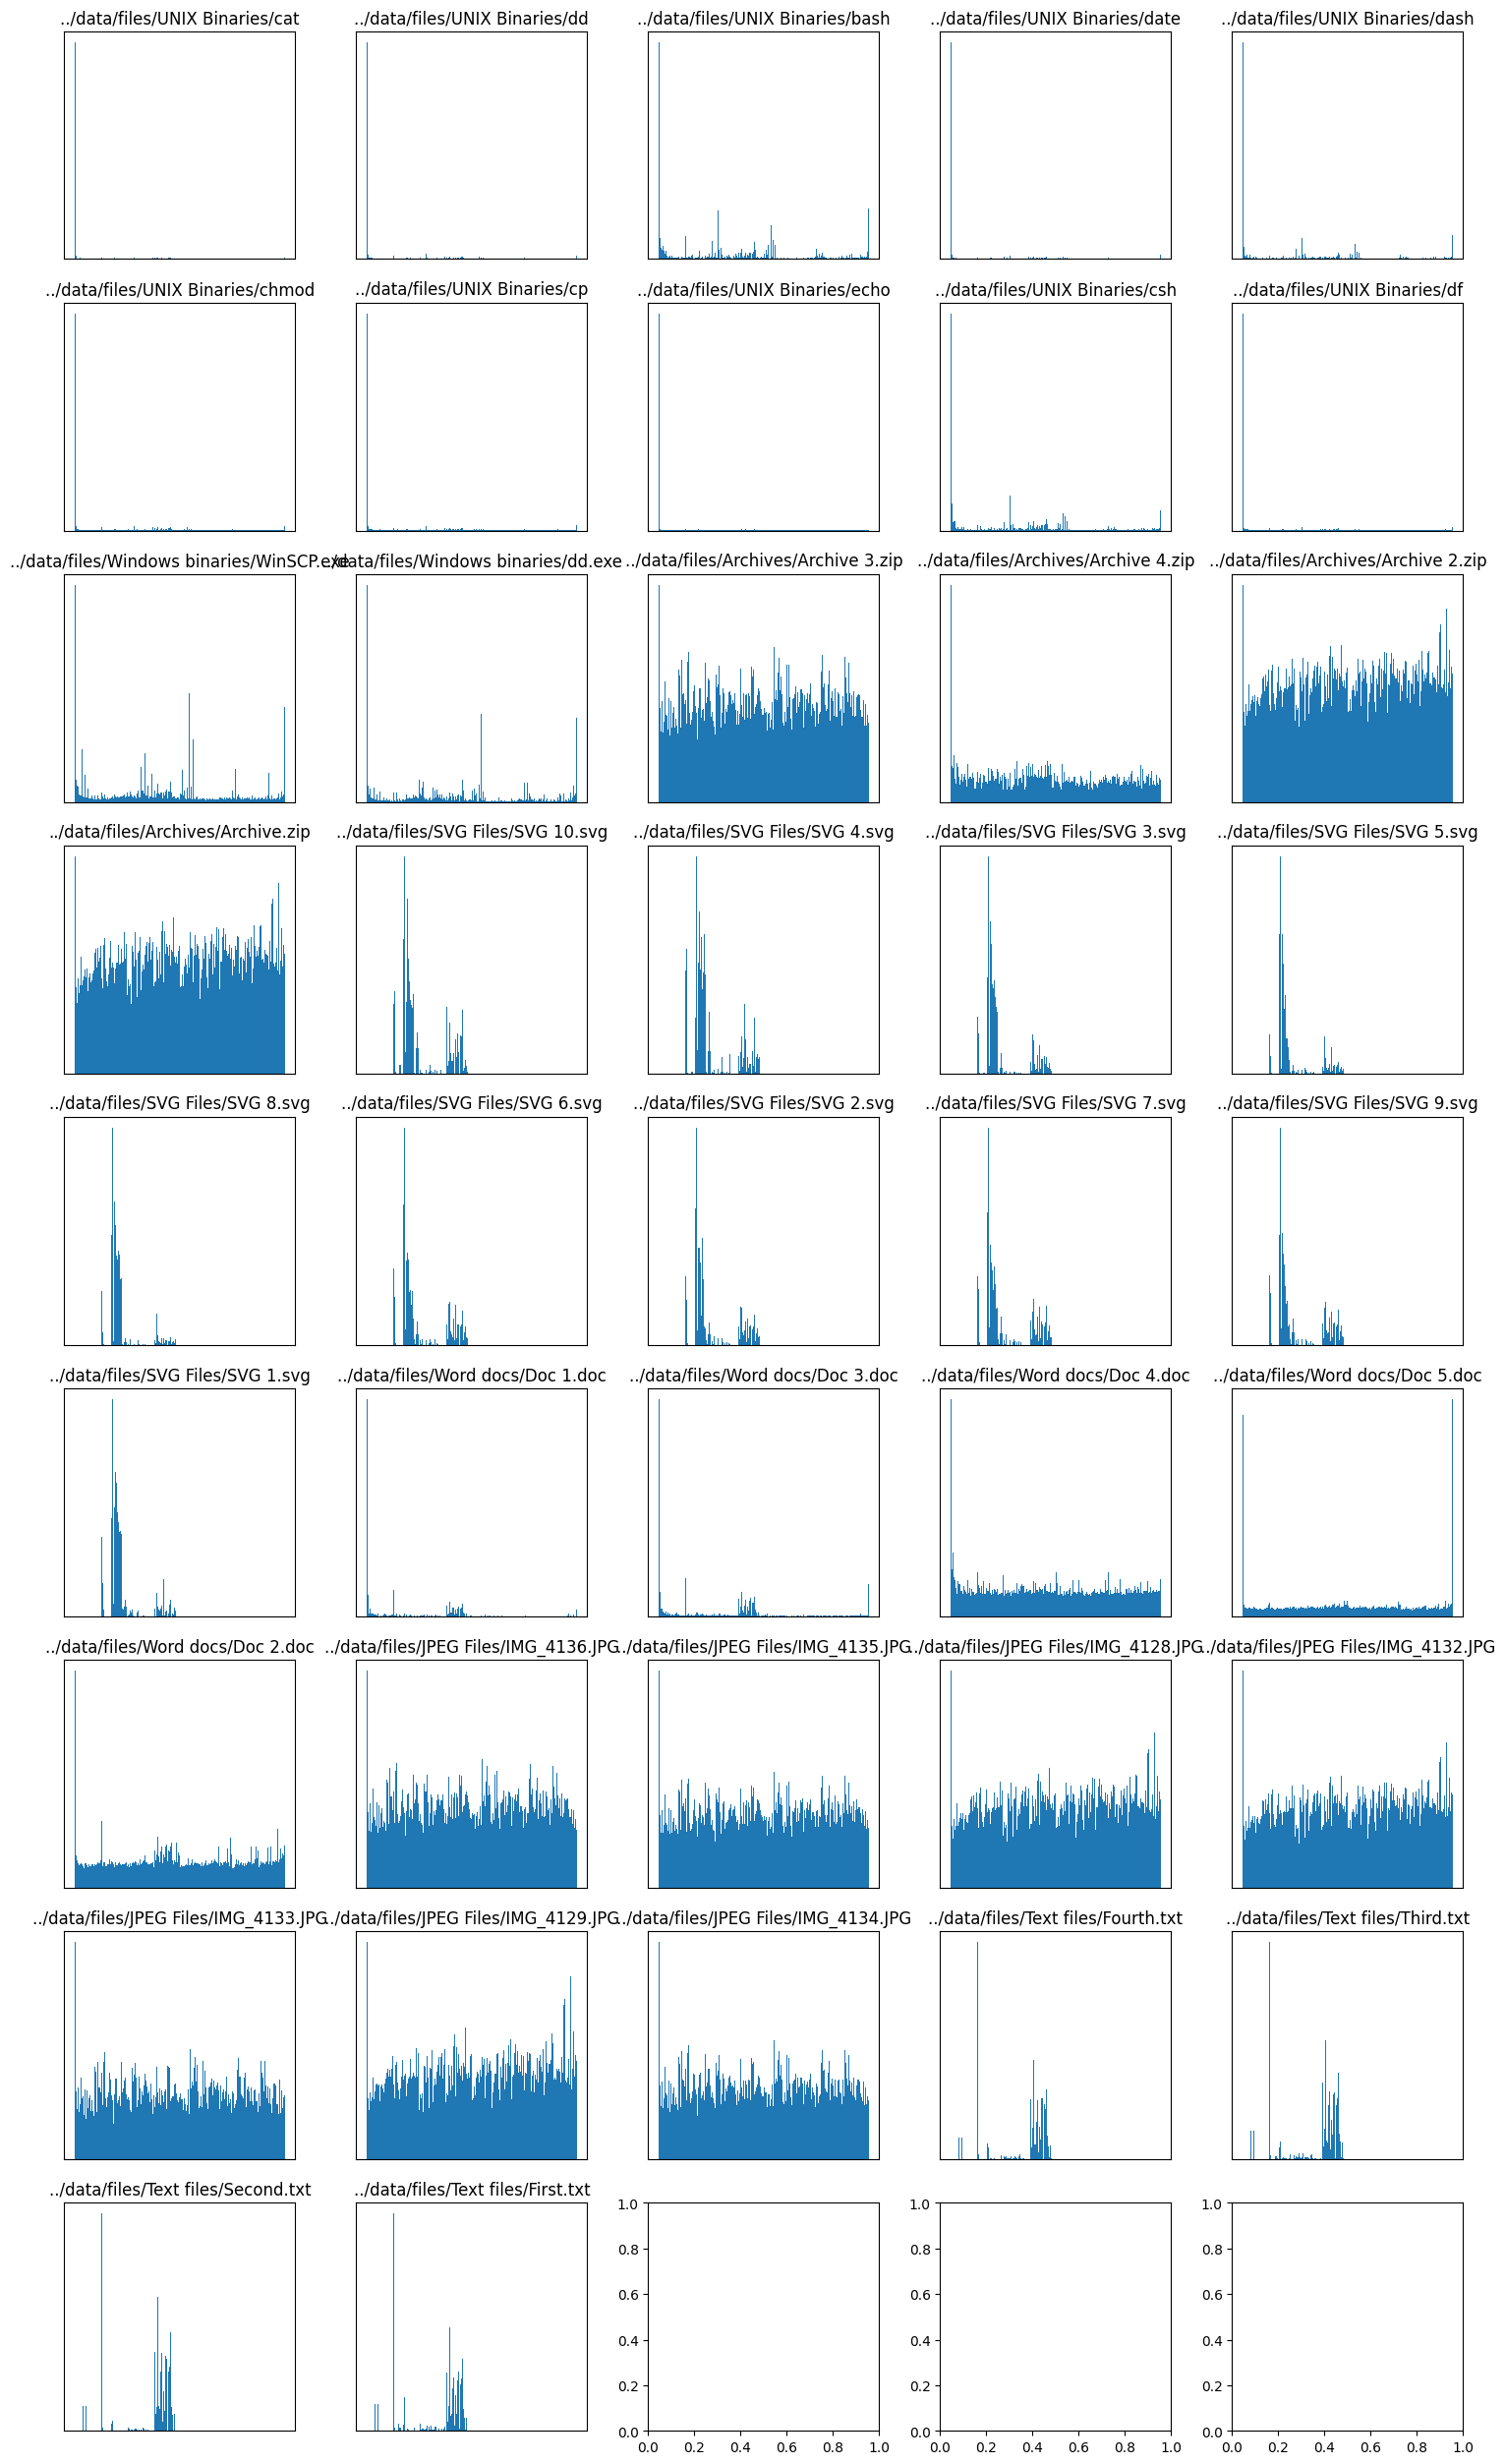

In [8]:
plt.rcParams["figure.figsize"] = (15, 25) # (w, h)

total_subplots = 0
for filetype in files:
    total_subplots += len(files[filetype])

print(f'{total_subplots} subplots required')
columns = 5
rows = int((total_subplots / columns) + 1)
print(f'Creating {rows}x{columns} grid')
figure, axes = plt.subplots(rows, columns)
figure.tight_layout()
plot_number = 0
for filetype in files:
    for filename in files[filetype]:
        plot_file(f'../data/files/{filetype}/{filename}', axes=axes[int(plot_number / columns), (plot_number % columns)] )
        plot_number += 1

plt.show()

As a part of exploratory data analysis, we said that we should "just look at it."  Of course, when you look at the data, whether as raw data or by plotting or transforming it in some way, you should think about what you are seeing.  For example, consider the JPEG files as compared to the plaintext files as compared to the SVG files.  Do you notice any significant differences?  Do you see any patterns?

Note that the text files and the SVG files have different concentrations of data, but they both seem to use the same bytes in the range from 0 to 255.  Why is this?  Can you explain it?  If you aren't sure, try opening an example of each and looking at the source or content of the files.

When you compare the JPEG to the text and SVG files, it should be very obvious that the JPEG format is using all of the byte values between 0 and 255, while the other two formats are not.  Why not?  Can you explain this?

Since SVG, or Structured Vector Graphics, files are just ASCII based descriptions of a vector image using an XML style language, it is no wonder that they share the same regions of bytes with text files.  Additionally, if you look at the concentrations of the two types of files, it makes a great deal of sense that a text file will tend to use a larger range of alphabetic characters, including a smaller number of capital letters, while SVG files will tend to use many numbers and some special characters or punctuation.  JPEG files, on the other hand, are binary data.  There is no need for the data to be restricted to only characters that are printable.

Visualizations are great... As humans, they really resonate with us.  Let's look at the data from a more mathematical perspective.

# <img src="../images/task.png" width=20 height=20> Task 3.7

Calculate and print the mean and the standard deviation for each file.  Then generate the mean and standard deviation for each file *type.*  Print these values and the comparison.

In [9]:
def get_file_stats(filename):
    with open(filename, 'rb') as f:
        file_bytes = bytearray(f.read())
    data = np.frombuffer(file_bytes, np.uint8)
    return(np.mean(data), np.std(data))


filetype_mean = {}
filetype_std = {}
for filetype in files:
    print(filetype)
    for filename in files[filetype]:
        (mean,std) = get_file_stats(f'../data/files/{filetype}/{filename}')
        print(f'\t{filename}:\t{mean}\t{std}')
        filetype_mean[filetype] = np.append(filetype_mean[filetype], np.array(mean)) if filetype in filetype_mean.keys() else np.array(mean)
        filetype_std[filetype] = np.append(filetype_std[filetype], np.array(std)) if filetype in filetype_std.keys() else np.array(std)

print(f'Filetype\tMean\tStandard Deviation')
for filetype in files:
    print(f'{filetype}\t{filetype_mean[filetype].mean()}\t{filetype_std[filetype].mean()}')

UNIX Binaries
	cat:	22.890230635335072	53.961130507096506
	dd:	36.81857269503546	64.47092794775851
	bash:	91.15302692021454	83.51393539555248
	date:	36.27424054260604	65.96283045271639
	dash:	73.40468930427252	83.79309287846569
	chmod:	40.22744583615437	67.55918550412908
	cp:	38.17725681302044	67.31954612916385
	echo:	18.801976714431934	48.554317207438125
	csh:	77.02289280425519	79.44555974376296
	df:	32.66054995617879	62.68880178467273
Windows binaries
	WinSCP.exe:	111.4811782228253	80.24037409692231
	dd.exe:	108.97129131394092	84.73565315770338
Archives
	Archive 3.zip:	127.60347840180562	73.48350883144164
	Archive 4.zip:	119.16954757252367	75.82767883926647
	Archive 2.zip:	130.91492549606775	73.66183170671034
	Archive.zip:	130.80703596690176	73.62082396617552
SVG Files
	SVG 10.svg:	63.063985374771484	26.169883765356904
	SVG 4.svg:	61.095327102803736	24.551160398026102
	SVG 3.svg:	58.62232905982906	22.67938918314996
	SVG 5.svg:	56.826486817903124	21.95515321675025
	SVG 8.svg:	53.65788

More than anything else that we have done, this last task should make you very conscious of the fact that plotting the data in a visualization is *very slow* compared to the raw processing of the data!  Still, we as humans like pictures, so we will continue to plot a number of things throughout the course.

Another "Aha!" moment should have happened when you look at the standard deviations and the averages.  For example, compare the file by file and the overall means and standard deviations for the JPEG and Zip files.  They are suspiciously similar!  Would it surprise you to discover that, while JPEG doesn't use Zip, JPEG produces a compressed image?

> As an aside, the matter of the JPEG and Zip files illustrates an important point.  It is not unusual for us to create a list of categories that contain things that we consider to be different, each from the other.  When we begin looking more closely at our data, however, we may come to realize that the differences between one or more classes of "things" are very small.  While we could invest a great deal of time in attempting to further differentiate two classes (such as Zip files and JPEG files), we should take a step back and ask ourselves whether the distinction is very important for the problem at hand.  For example, would it be sufficient in this case to create a bucket of things that we call "compressed files" rather than distinguishing between JPEG and ZIP?  At least in this case, that distinction is not terribly important.

The Windows and UNIX binaries are also interesting!  Here, the fact that they are so different is what is interesting.  Given additional research using many more sample binaries, could it turn out that we can trivially distinguish one from the other using the mean and the standard deviation?

We'd like to get back to our primary hypothesis, however.  We were most interested in how unencrypted files differ from encrypted files.  Let's find out!

To do so, we need a utility function that can encrypt our data for us.  Encrypting the data turns out to be pretty simple:

```
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

key = os.urandom(32)
iv = os.urandom(16)
aes_cipher = Cipher(algorithms.AES(key), modes.GCM(iv))
encryptor = aes_cipher.encryptor()
ciphertext = encryptor.update(file_bytes) + encryptor.finalize()
```

# <img src="../images/task.png" width=20 height=20> Task 3.8

Using the above code as a template, build a second function that will read a file, encrypt the data, and then produce the mean and standard deviation of the resulting bytes as a returned tuple.

In [10]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

def encrypt_and_stats(filename):
    with open(filename, 'rb') as f:
        file_bytes = bytearray(f.read())
    key = os.urandom(32)
    iv =os.urandom(16)
    aes_cipher = Cipher(algorithms.AES(key), modes.GCM(iv))
    encryptor = aes_cipher.encryptor()
    ciphertext = encryptor.update(file_bytes) + encryptor.finalize()
    data = np.frombuffer(ciphertext, np.uint8)
    return(np.mean(data), np.std(data))

encrypt_and_stats('../data/files/Archives/Archive.zip')

(127.50315085800686, 73.89082997515962)

Now that we have that working, let's compute and print all of the means and standard deviations for all of the files and then the filetypes.

# <img src="../images/task.png" width=20 height=20> Task 3.9

Print a table that shows each filename, encrypted mean, and encrypted standard deviation.  Following this, print a table showing the average encrypted mean and the average encrypted standard deviation.

In [11]:
filetype_mean = {}
filetype_std = {}
for filetype in files:
    print(filetype)
    for filename in files[filetype]:
        (mean,std) = encrypt_and_stats(f'../data/files/{filetype}/{filename}')
        print(f'\t{filename}:\t{mean}\t{std}')
        filetype_mean[filetype] = np.append(filetype_mean[filetype], np.array(mean)) if filetype in filetype_mean.keys() else np.array(mean)
        filetype_std[filetype] = np.append(filetype_std[filetype], np.array(std)) if filetype in filetype_std.keys() else np.array(std)

print(f'Filetype\tMean\tStandard Deviation')
for filetype in files:
    print(f'{filetype}\t{filetype_mean[filetype].mean()}\t{filetype_std[filetype].mean()}')

UNIX Binaries
	cat:	127.51384355961706	74.05849555273367
	dd:	127.16826241134751	73.93145314412575
	bash:	127.46006877614391	73.91254688141025
	date:	128.08561807413068	73.86805300246745
	dash:	127.42949805138568	73.63259023697603
	chmod:	127.53410629654705	73.84807334173723
	cp:	127.78179409538228	74.01970553221928
	echo:	127.49392272262027	74.32013780072461
	csh:	127.4056824020067	73.94897532162763
	df:	127.75657318141981	74.1216179900498
Windows binaries
	WinSCP.exe:	127.494799199713	73.90919377304687
	dd.exe:	127.34800522334294	73.87409349548643
Archives
	Archive 3.zip:	127.44784390414839	73.90024060818425
	Archive 4.zip:	127.27957312490605	74.90480354935472
	Archive 2.zip:	127.45655880581523	73.92127782997188
	Archive.zip:	127.53424312092874	73.91349860952188
SVG Files
	SVG 10.svg:	127.30054844606947	73.62374564579527
	SVG 4.svg:	127.16907391673747	73.67588526726722
	SVG 3.svg:	127.36378205128206	74.04590883776508
	SVG 5.svg:	128.08828939301043	73.81735163086559
	SVG 8.svg:	129.34

The output is *very* interesting!  Notice that the average for every filetype is nearly identical, as is the standard deviation.  Think about this for just a moment.  *This is exactly what we would expect.*  If encrypting different data results in differing statistics, it would provide a way to reveal information about the original data without the key.

This said, there *is* something a little bit odd.  

# <img src="../images/task.png" width=20 height=20> Task 3.10

Please plot a histogram of the encrypted bytes from a single file.

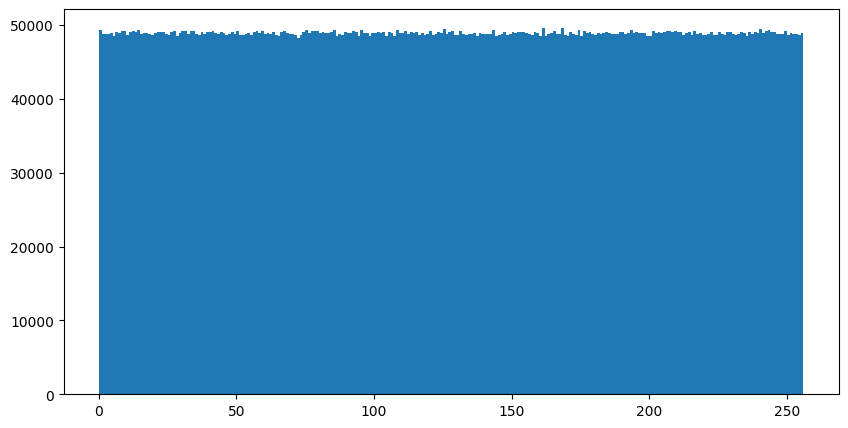

(127.49064154173317, 73.90703171593232)

In [12]:
def encrypt_plot_and_stats(filename):
    with open(filename, 'rb') as f:
        file_bytes = bytearray(f.read())
    key = os.urandom(32)
    iv =os.urandom(16)
    aes_cipher = Cipher(algorithms.AES(key), modes.GCM(iv))
    encryptor = aes_cipher.encryptor()
    ciphertext = encryptor.update(file_bytes) + encryptor.finalize()
    data = np.frombuffer(ciphertext, np.uint8)
    plt.figure(figsize=(10,5))
    plt.hist(data, bins=range(0,257))
    plt.show()
    return(np.mean(data), np.std(data))

encrypt_plot_and_stats('../data/files/Archives/Archive 2.zip')

Now *that's* interesting!  It turns out that the AES algorithm does produce a pretty flat histogram, but there are nearly two times the average bytes that contain 255.  It is crystal clear that there is very little variance in the frequency with which each value appears.

That last statement should give you pause.  We just said that it seems that there is *very little* variance in the frequency of each byte.  However, the standard deviation, effectively the square root of the variance, is 73.89.  That doesn't seem *minimal.*  What's happening?

The standard deviation what we have calculated so far is for *the data overall.*  A more interesting statistic might be described using the words in the paragraphs just above; the standard deviation of the *frequency with which each value appears.*  In other words, rather than asking, "What is the standard deviation of the byte values?" which is what we have calculated so far, we are instead standing back further asking about the frequency with which each appears.

# <img src="../images/task.png" width=20 height=20> Task 3.11

Write some Python code to determine the frequency with which each byte appears in our encrypted data.  Then generate the standard deviation of *this* data and think about it.  

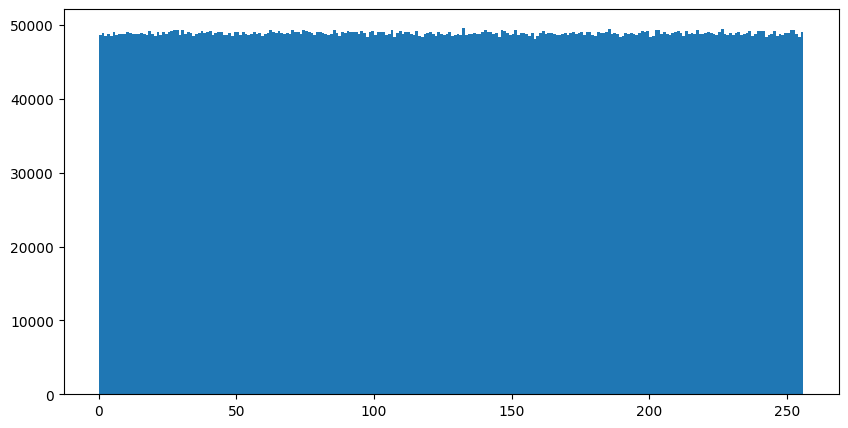

Mean frequency:48896.06640625	stddev of frequencies: 240.0434032294159
Minimum frequency: 48105	Maximum frequency:49663
Percentage of stddev relative to the mean: 0.4909257960242238%


In [13]:
def encrypt_plot_and_stats(filename):
    with open(filename, 'rb') as f:
        file_bytes = bytearray(f.read())
    key = os.urandom(32)
    iv =os.urandom(16)
    aes_cipher = Cipher(algorithms.AES(key), modes.GCM(iv))
    encryptor = aes_cipher.encryptor()
    ciphertext = encryptor.update(file_bytes) + encryptor.finalize()
    data = np.frombuffer(ciphertext, np.uint8)
    byte_frequencies = []
    for i in range(0,256):
        byte_frequencies.append(len(data[np.where(data == i)]))
    byte_frequencies = np.array(byte_frequencies)

    plt.figure(figsize=(10,5))
    plt.hist(data, bins=range(0,257))
    plt.show()
    print(f'Mean frequency:{byte_frequencies.mean()}\tstddev of frequencies: {byte_frequencies.std()}')
    print(f'Minimum frequency: {byte_frequencies.min()}\tMaximum frequency:{byte_frequencies.max()}')
    print(f'Percentage of stddev relative to the mean: {(byte_frequencies.std() / byte_frequencies.mean()) * 100.0}%')

encrypt_plot_and_stats('../data/files/Archives/Archive 2.zip')

Let's attach one more metric to this.  A standard deviation of 212 can *seem* like a very large measure of variation.  What if we consider it as a percentage of the average?  If we encrypt the *Archive 2.zip* file we find that this seemingly large deviation is less than 0.5%!

# Conclusion

So what can we take away from this exercise?  First, we have definitely proven our hypothesis.  That is, we can *absolutely* identify encrypted data by examining the overall variance of the data relative to the frequency with which any given byte appears in the data.  We also had the opportunity to manipulate the data in a variety of ways, realizing that the straightforward average and standard deviation applied to the data itself was not nearly as interesting as the 2nd or 3rd order application of these functions.

What we've learned:

* How to manipulate Numpy arrays effectively to filter data
* How the theorize, experiment, and evaluate data during the data exploration phase
* A better understanding of what variance and standard deviation mean and what they can be used for